# Code to export pfisr data for SIC model run

written by Riley Troyer Spring 2022

In [12]:
# Libraries
from datetime import datetime as dt
import gc
import h5py
from matplotlib import pyplot as plt
import msise00
import numpy as np
import os
import pandas as pd
from scipy.interpolate import interp1d

## The first thing I do is read in a config file with various parameters that I could change from run to run.

In [2]:
# Read in config file with dictionary of specified inputs
import config_example as config
config_data = config.run_info['config_info']

# Path to pfisr data directory
pfisr_data_dir = config_data['isr_data_dir']

# File with times for events of interest
reference_file = config_data['event_file']

# Get location of PFISR
pfrr_lat = config_data['isr_lat']
pfrr_lon = config_data['isr_lon']

# Define test flux in m^-2 s^-1
F = config_data['test_flux']

# Don't use PFISR data below this altitude in km
pfisr_min_alt = config_data['isr_min_alt']

# Get sensitivity limit of PFISR
pfisr_sensitivity = config_data['isr_sensitivity']

# Altitude in meters to approximate infinity when calculating
#...mass distance
max_msis_alt = config_data['max_msis_alt']

# Maximum number of iterations to run maximum entropy process on
max_iterations = config_data['max_iterations']

# Reduced chi square to aim for
convergence = config_data['convergence']

# Define arrays for altitude and energy bins

# Altitude in meters
#...number of points should be around the same as pfisr data
altitude_bins = config_data['altitude_bins']

# Energies in eV
#...should probably be less than altitude bins to avoid overfitting
energy_bins = config_data['energy_bins']

# Get which chemistry model to use
alpha_type = config_data['alpha_type']

# Get files to run code for
pfisr_files = config.run_info['run_files']

In [3]:
# For example code just use one file
pfisr_filename = pfisr_files[0]
#pfisr_filename = pfisr_files[12]
#pfisr_filename = pfisr_files[56]
#pfisr_filename = '20080326.001_bc_1min-fitcal.h5'

In [4]:
pfisr_filename

'20120328.001_bc_nenotr_1min.h5'

## Next I read in a file containing the ISR data.

In [5]:
def get_isr_data(pfisr_filename, pfisr_data_dir):
    """Function to get relevant data from PFISR datafile.
    INPUT
    pfisr_filename
        type: str
        about: data file name, should be .h5 file
    pfisr_data_dir
        type: str
        about: directory where isr data is stored
    OUTPUT
    utc_time
        type: array of datetimes
        about: time stamp for the start of each measurement
    pfisr_altitude
        type: array of float
        about: altitude stamp for each measurement in meters
    e_density
        type: array of float
        about: electron number density in m^-3
    de_density
        type: array of float
        about: error in number density
    """
    
    # Read in the h5 file
    pfisr_file = h5py.File(pfisr_data_dir + pfisr_filename, 'r')

    # Get the different beams and select specified angle
    beam_angle = 90
    beams = np.array(pfisr_file['BeamCodes'])

    # Get the beam with a 90 degree elevation angle
    indexes = np.linspace(0, len(beams)-1, len(beams))
    beam_num = int(indexes[np.abs(beams[:,2] - beam_angle) == 0][0])

    # Get time and convert to utc datetime
    unix_time = np.array(pfisr_file['Time']['UnixTime'])[:,0]
    utc_time = np.array([dt.utcfromtimestamp(d) for d in unix_time])

    # Get the altitude array
    pfisr_altitude = np.array(pfisr_file['NeFromPower']
                              ['Altitude'])[beam_num, :]

    # Get the uncorrected number density array
    e_density = np.array(pfisr_file['NeFromPower']
                         ['Ne_NoTr'])[:, beam_num, :]

    # Take the transpose
    e_density = np.transpose(e_density)
    
    # Find the noise floor by averaging between 55km and 60km
    #...assume this should be zero
    noise_floor = np.mean(e_density[(pfisr_altitude > 55000)
                                    & (pfisr_altitude < 60000), :],
                          axis=0)
    
    # Loop through each column and subtract off noise floor
    for j in range(e_density.shape[1]):
        e_density[:, j] = e_density[:, j] - noise_floor[j]
    
    # Get error values
    try:
        de_density = np.array(pfisr_file['NeFromPower']
                              ['errNe_NoTr'])[:, beam_num, :]
        de_density = np.transpose(de_density)
    except:
        de_density = np.array(pfisr_file['NeFromPower']
                              ['dNeFrac'])[:, beam_num, :]
        de_density = np.transpose(de_density)
        de_density = de_density * e_density

    # Close file
    pfisr_file.close()
    
    return utc_time, unix_time, pfisr_altitude, e_density, de_density

In [6]:
# Read in the pfisr data
(utc_time, unix_time, 
 pfisr_altitude,
 e_density, de_density) = get_isr_data(pfisr_filename, pfisr_data_dir)

## Events of interest are usually only a small portion of the ISR data, so to speed up the analysis it's useful to select only these periods

In [7]:
def find_event_indices(utc_time):
    """Function to find only indices of times of interest.
    INPUT
    utc_time
        type: array of datetimes
        about: utc datetimes of all pfisr data
    OUTPUT
    slices_n
        type: list of integers
        about: indices of pfisr data that is of interest
    """
    
    # Find the date for the current pfisr file, this is a little tricky as
    #...some pfisr files span multiple days
    pfisr_dates = np.unique(np.array([d.date() for d in utc_time]))

    # Dates that are in both pa database and pfisr file
    pa_pfisr_dates = np.unique(np.array([d for d in pa_dates 
                                         if d in pfisr_dates]))

    # Loop through each of these dates and get correct indices
    indices = []
    for date in pa_pfisr_dates:
            indices.append(np.argwhere(pa_dates == date))

    # Flatten list of indices
    indices = [item[0] for sublist in indices for item in sublist]

    # Loop through each index and get data slices corresponding to the
    #...start and stop times
    slices_n = []
    for index in indices:

        # Get the date and start time of measurements
        date = pa_database[index, 0]
        start_time = date + ' ' + pa_database[index, 1]
        end_time = date + ' ' + pa_database[index, 2]

        # Convert to datetime
        start_time = dt.strptime(start_time, '%Y-%m-%d %H:%M:%S')
        end_time = dt.strptime(end_time, '%Y-%m-%d %H:%M:%S')

        # Find which indices in pfisr data correspond
        slices_n.append(np.argwhere((utc_time >= start_time) 
                                    & (utc_time <= end_time)))

    # Flatten pfisr array indices
    slices_n = [item[0] for sublist in slices_n for item in sublist]
    
    return slices_n

In [8]:
# Read in file with pulsating aurora dates, times and types
pa_database = np.loadtxt(reference_file, delimiter='\t', dtype=str)
pa_database = pa_database[1:, :]

# Convert dates to datetimes
pa_dates = np.array([dt.strptime(d, '%Y-%m-%d').date() for d 
                     in pa_database[:, 0]])

slices_n = find_event_indices(utc_time)

## Get only a single slice of data

In [9]:
# Time slice to run inversion for
#slice_n = 684
slice_n = 663
print(utc_time[slice_n])

2012-03-28 11:05:52


In [10]:
# Time associated with slice
run_time = utc_time[slice_n]

# Get PFISR data for slice

# Read in density and errors in those measurements
#...for specific time
e_density_slice = e_density[:, slice_n]
de_density_slice = de_density[:, slice_n]

# Make interpolation model of this data with respect to altitude
#...but only do this for altitudes > defined minimum value,
#...below this data can be weird
pfisr_density_interp = interp1d(pfisr_altitude, e_density_slice)

# Same interpolation except for error in density
pfisr_error_interp = interp1d(pfisr_altitude, de_density_slice)

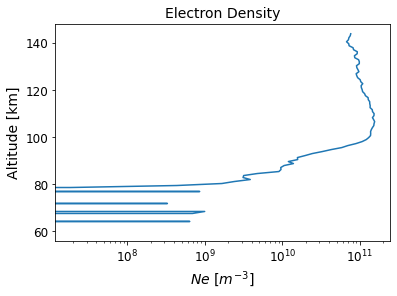

In [16]:
# Plot electron density
fig, ax = plt.subplots()

# Title and axis
ax.set_title('Electron Density', fontsize=14)

ax.set_xlabel(r'$Ne$ $[m^{-3}]$', fontsize=14)
ax.set_ylabel('Altitude [km]', fontsize=14)

# Plot the rates
ax.plot(pfisr_density_interp(altitude_bins), altitude_bins/1000)
ax.set_xscale('log')
ax.tick_params(labelsize=12)

## Write the data to an excel file

In [71]:
# Data to include in dataframe
d = {'UTC': run_time,
     'Geographic Latitude': pfrr_lat,
     'Geographic Longitude' : pfrr_lon,
     'Altitude (m)' : altitude_bins,
     'Electron Density (m^-3)': pfisr_density_interp(altitude_bins)}

# Create the dataframe
pfisr_sic_data = pd.DataFrame(data = d)

# Write to csv file
csv_filename = '../source-energy-pa/data/pfisr-data/data-for-sic/time4.csv'
pfisr_sic_data.to_csv(csv_filename)